In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
df = pd.read_csv("data.csv", encoding="latin1")

x = df["no2"].dropna().values  

x = x.astype(np.float32)

print("Number of samples:", len(x))

/var/folders/83/308cnjqn2dz8h3lcgy6q00w00000gn/T/ipykernel_27239/3323748902.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data.csv", encoding="latin1")


Number of samples: 419509


In [14]:
r = 102317137  

a_r = 0.5 * (r % 7)
b_r = 0.3 * ((r % 5) + 1)

print("a_r =", a_r)
print("b_r =", b_r)

a_r = 3.0
b_r = 0.8999999999999999


In [ ]:
z = x + a_r * np.sin(b_r * x)

z_mean = z.mean()
z_std = z.std()

z = (z - z_mean) / z_std

In [16]:
z_tensor = torch.tensor(z).view(-1, 1)

dataset = TensorDataset(z_tensor)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [17]:
class Generator(nn.Module):
    def __init__(self, noise_dim=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, z):
        return self.model(z)

In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [19]:
noise_dim = 10

G = Generator(noise_dim)
D = Discriminator()

criterion = nn.BCELoss()

optimizer_G = optim.Adam(G.parameters(), lr=0.0002)
optimizer_D = optim.Adam(D.parameters(), lr=0.0002)

In [20]:
epochs = 150
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G.to(device)
D.to(device)

for epoch in range(epochs):
    for real_batch in dataloader:
        real_samples = real_batch[0].to(device)
        batch_size = real_samples.size(0)

        # Labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ---------------------
        # Train Discriminator
        # ---------------------
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_samples = G(noise)

        D_real = D(real_samples)
        D_fake = D(fake_samples.detach())

        loss_D_real = criterion(D_real, real_labels)
        loss_D_fake = criterion(D_fake, fake_labels)

        loss_D = loss_D_real + loss_D_fake

        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # ---------------------
        # Train Generator
        # ---------------------
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_samples = G(noise)
        D_fake = D(fake_samples)

        loss_G = criterion(D_fake, real_labels)

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    if epoch % 20 == 0:
        print(f"Epoch [{epoch}/{epochs}] | Loss D: {loss_D.item():.4f} | Loss G: {loss_G.item():.4f}")

Epoch [0/150] | Loss D: 1.3803 | Loss G: 0.6986
Epoch [20/150] | Loss D: 1.3471 | Loss G: 0.6676
Epoch [40/150] | Loss D: 1.3855 | Loss G: 0.6964
Epoch [60/150] | Loss D: 1.3885 | Loss G: 0.6997
Epoch [80/150] | Loss D: 1.3869 | Loss G: 0.6961
Epoch [100/150] | Loss D: 1.3864 | Loss G: 0.6970
Epoch [120/150] | Loss D: 1.3886 | Loss G: 0.6940
Epoch [140/150] | Loss D: 1.3861 | Loss G: 0.7036


In [21]:
G.eval()

with torch.no_grad():
    noise = torch.randn(10000, noise_dim).to(device)
    fake_samples = G(noise).cpu().numpy()

# De-normalize
fake_samples = fake_samples * z_std + z_mean
z_original = z * z_std + z_mean

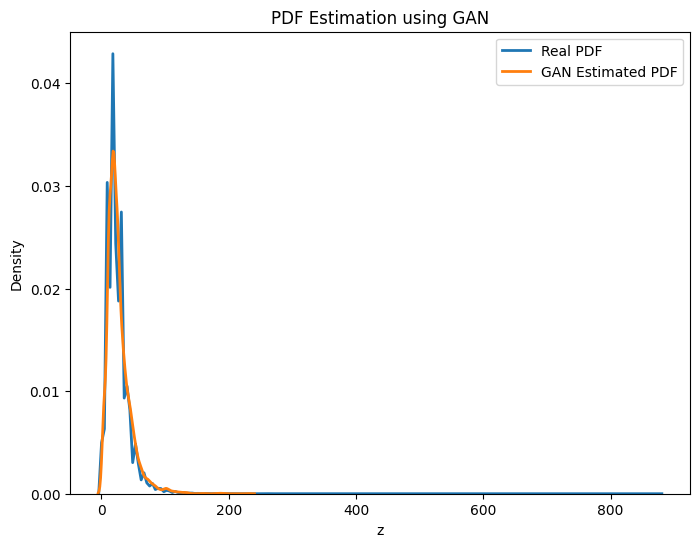

In [22]:
plt.figure(figsize=(8,6))

sns.kdeplot(z_original, label="Real PDF", linewidth=2)
sns.kdeplot(fake_samples.flatten(), label="GAN Estimated PDF", linewidth=2)

plt.legend()
plt.title("PDF Estimation using GAN")
plt.xlabel("z")
plt.ylabel("Density")
plt.show()